In [1]:
import pygsp as p
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import cv2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
image = cv2.imread("imgs/im_proc/cameraman.jpg")

In [3]:
y, x, t = 30, 90, 80
crop_image = image[y:y+t, x:x+t]

In [4]:
crop_image_flatten = crop_image.reshape(t ** 2, 3).T/255

In [5]:
np.shape(crop_image_flatten) #tentar gft na imagem cortada 80x80

(3, 6400)

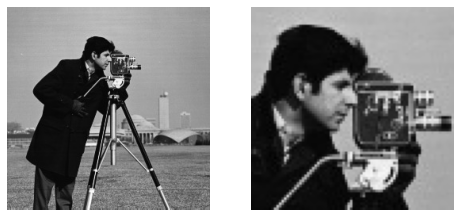

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image)
ax[1].imshow(crop_image)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [8]:
mu, sigma =0, 0.1

r_noisy = crop_image_flatten[0] + np.random.normal(mu, sigma, size = len(crop_image_flatten[0]))
g_noisy = crop_image_flatten[1] + np.random.normal(mu, sigma, size = len(crop_image_flatten[1]))
b_noisy = crop_image_flatten[2] + np.random.normal(mu, sigma, size = len(crop_image_flatten[2]))

crop_image_noisy = np.array([r_noisy, g_noisy, b_noisy])

In [9]:
np.shape(crop_image_noisy)

(3, 6400)

In [10]:
np.shape(r_noisy)

(6400,)

In [11]:
crop_image_noisy = crop_image_noisy.T.reshape(t, t, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


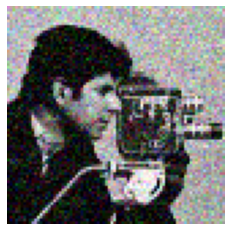

In [12]:
plt.imshow(crop_image_noisy)
plt.axis('off')
plt.show()

In [13]:
G = p.graphs.Grid2d(t, t)

In [14]:
np.shape(crop_image_flatten[0]), np.shape(r_noisy)

((6400,), (6400,))

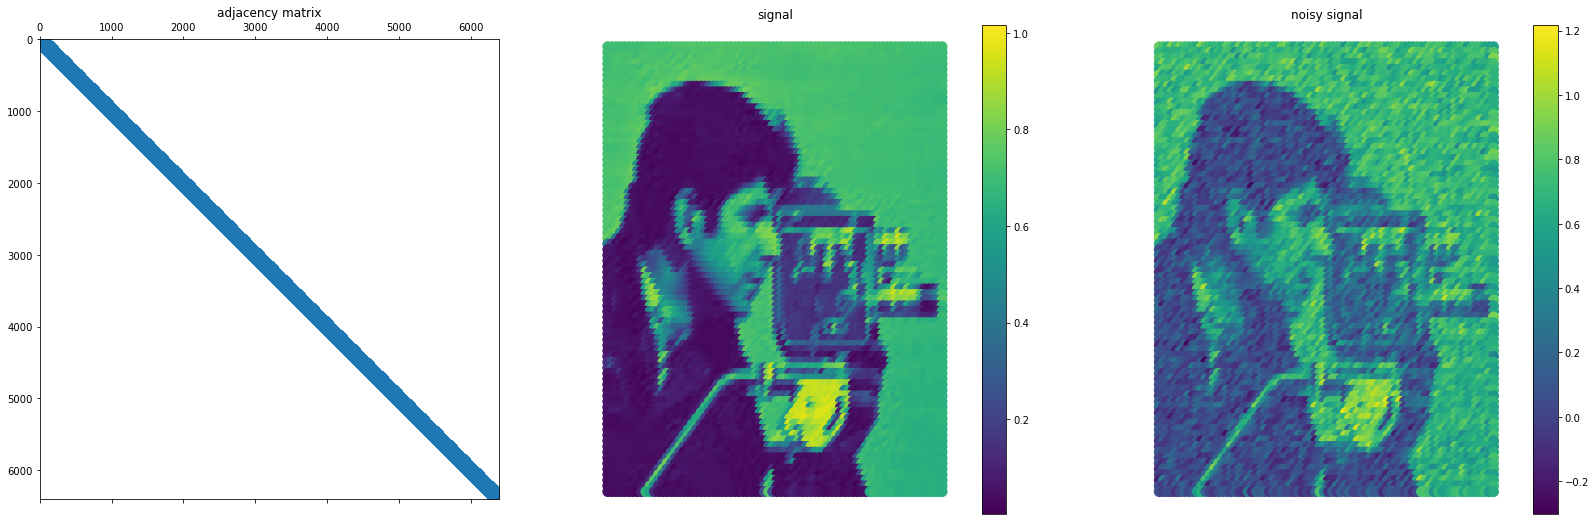

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (28, 9))
ax[0].spy(G.W, markersize=5)
G.plot_signal(crop_image_flatten[0], ax=ax[1]) #plot do sinal é a imagem
G.plot_signal(r_noisy, ax=ax[2]) #plot do sinal é a imagem
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('adjacency matrix')
ax[1].set_title('signal')
ax[2].set_title('noisy signal')
plt.show()
#descobrir como mudar colormap do pygsp

In [16]:
%%time
G.compute_fourier_basis()

2022-05-07 04:04:50,899:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (6400 x 6400) may take some time.


CPU times: user 2min 34s, sys: 4.75 s, total: 2min 38s
Wall time: 22.2 s


In [17]:
%%time
r_hat, g_hat, b_hat = G.gft(r_noisy), G.gft(g_noisy), G.gft(b_noisy) # transformada de fourier 

CPU times: user 3.02 s, sys: 734 ms, total: 3.75 s
Wall time: 1.04 s


In [18]:
%%time
r_star, g_star, b_star = G.igft(r_hat), G.igft(g_hat), G.igft(b_hat) #transformada da matriz inversa

CPU times: user 266 ms, sys: 0 ns, total: 266 ms
Wall time: 40.3 ms


In [19]:
max(r_noisy - r_star), max(g_noisy - g_star), max(b_noisy - b_star) #boa aproximação

(1.1324274851176597e-14, 9.103828801926284e-15, 6.661338147750939e-15)

In [20]:
tau = 1
def h(x):
    return 1. / (1. + tau * x)
g = p.filters.Filter(G, h)

In [21]:
%%time
r_denoised, g_denoised, b_denoised = g.filter(r_noisy, method='exact'), g.filter(g_noisy, method='exact'), g.filter(b_noisy, method='exact')

CPU times: user 4.41 s, sys: 844 ms, total: 5.25 s
Wall time: 1.09 s


In [22]:
%%time
r_denoised_hat, g_denoised_hat, b_denoised_hat = G.gft(r_denoised), G.gft(g_denoised), G.gft(b_denoised)

CPU times: user 3.89 s, sys: 844 ms, total: 4.73 s
Wall time: 1.03 s


In [23]:
denoised_crop_image = np.array([r_denoised, g_denoised, b_denoised]).T.reshape(t, t, 3)

In [24]:
np.shape(crop_image_noisy)

(80, 80, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


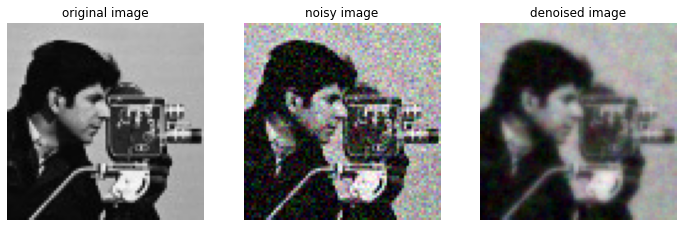

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (12, 12))

ax[0].imshow(crop_image)
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(crop_image_noisy)
ax[1].axis('off')
ax[1].set_title('noisy image')

ax[2].imshow(denoised_crop_image)
ax[2].axis('off')
ax[2].set_title('denoised image')

plt.show()

In [26]:
max(np.abs(r_noisy - crop_image_flatten[0])), max(np.abs(g_noisy - crop_image_flatten[1])), max(np.abs(b_noisy - crop_image_flatten[2]))

(0.3971923619714433, 0.44386022466742836, 0.3669082687888533)

In [27]:
max(np.abs(r_denoised - crop_image_flatten[0])), max(np.abs(g_denoised - crop_image_flatten[1])), max(np.abs(b_denoised - crop_image_flatten[2]))

(0.41771946259089776, 0.43259957792972403, 0.41549588254105874)

In [28]:
#definir grafo diferente com diagonais entre pixels